In [1]:
#import all libraries and dependencies

%matplotlib inline

from time import perf_counter 
import os
import sys
import matplotlib.pyplot as plt
import osmnx as ox 
from collections import Counter
import pygal
import pandas as pd, numpy as np, matplotlib.pyplot as plt, time
import matplotlib

#Interactive visualization
import folium
from folium import plugins
# Adds tool to the top right
from folium.plugins import MeasureControl
from folium.plugins import FastMarkerCluster
import branca.colormap as cm
from IPython.display import HTML

import seaborn as sns; sns.set()

from sklearn.cluster import DBSCAN
from geopy.distance import great_circle
from shapely.geometry import MultiPoint

from sklearn.mixture import GaussianMixture
from sklearn.datasets import make_moons
from sklearn import metrics

from pygeocoder import Geocoder 

import reverse_geocoder as rg #info. on output:(name: cityname, admin1:state, admin2:county, cc:country code): https://github.com/thampiman/reverse-geocoder
import pprint 

from sklearn.datasets import make_blobs
from sklearn.metrics import silhouette_samples, silhouette_score
from plotly import tools
import matplotlib.cm as cm
import plotly.graph_objs as go

import random

from kneed.data_generator import DataGenerator
from kneed.knee_locator import KneeLocator

import hdbscan
from sklearn.datasets import make_blobs

import datetime


/anaconda3/envs/gmm/lib/python3.7/site-packages/sklearn/externals/six.py:31: DeprecationWarning:

The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).

/anaconda3/envs/gmm/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning:

sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.



In [2]:
##  # To Compute Haversine distance
def sphere_dist(o_lat, o_lon, d_lat, d_lon):
    """
    Return distance along great radius between origin and destination coordinates.
    """
    #Define earth radius (km)
    R_earth = 6371
    #Convert degrees to radians
    o_lat, o_lon, d_lat, d_lon = map(np.radians,
                                                             [o_lat, o_lon, 
                                                              d_lat, d_lon])
    #Compute distances along lat, lon dimensions
    dlat = d_lat - o_lat
    dlon = d_lon - o_lon
    
    #Compute haversine distance
    a = np.sin(dlat/2.0)**2 + np.cos(o_lat) * np.cos(d_lat) * np.sin(dlon/2.0)**2
    return 2 * R_earth * np.arcsin(np.sqrt(a))

def radian_conv(degree):
    """
    Return radian.
    """
    return  np.radians(degree) 

In [3]:
#Courtesy of https://stackoverflow.com/questions/26079881/kl-divergence-of-two-gmms. Here the difference is that we take the squared root, so it's a proper metric

def gmm_js(gmm_p, gmm_q, n_samples=10**5):
    X = gmm_p.sample(n_samples)[0]
    log_p_X = gmm_p.score_samples(X)
    log_q_X = gmm_q.score_samples(X)
    log_mix_X = np.logaddexp(log_p_X, log_q_X)

    Y = gmm_q.sample(n_samples)[0]
    log_p_Y = gmm_p.score_samples(Y)
    log_q_Y = gmm_q.score_samples(Y)
    log_mix_Y = np.logaddexp(log_p_Y, log_q_Y)
    
    return np.sqrt((log_p_X.mean() - (log_mix_X.mean() - np.log(2))
            + log_q_Y.mean() - (log_mix_Y.mean() - np.log(2))) / 2)

In [4]:
# Input Training Dataset for the Model

def ReadFromCSV(FilePath, sckipLines = 0, sep = ','):  

    #Read and clean the csv file in FilePath ignoring the first sckipLines lines.

    #(omits non-ascii characters from columns' name)

    xa = pd.read_csv(FilePath, header=sckipLines, sep = sep, low_memory=False)

    return xa



In [5]:
def data_manipulation(J):
    
    ## clean the data from non meaningful lat. and long.
    # ##### Valid range of latitude and longitude for India: lat range( 8°4′ N to 37°6′ N) & long. range( 68°7′ E to 97°25′ E)
    
    J=J[(J['origin_lat'] >= 8) & (J['origin_lat'] <= 38)  & (J['destination_lat'] >= 8) & (J['destination_lat']<=38)]
    J=J[(J['origin_lng'] >= 67) & (J['origin_lng'] <= 98)  & (J['destination_lng'] >= 67) & (J['destination_lng']<=98)]                            
               
    J_clean=J.loc[(J['origin_lng'] >= 67) & (J['destination_lng'] <= 98)]
    
    
    # ### Jitter in lat/long of cols ==> The second decimal place is worth up to 1.1 km

    J_clean['origin_lat']=J_clean['origin_lat'].map(lambda x: x +np.random.rand()/5.0)
    J_clean['origin_lng']=J_clean['origin_lng'].map(lambda x: x +np.random.rand()/5.0)

    J_clean['destination_lat']=J_clean['destination_lat'].map(lambda x: x +np.random.rand()/5.0)
    J_clean['destination_lng']=J_clean['destination_lng'].map(lambda x: x +np.random.rand()/5.0)
    
    J_clean=J_clean.dropna() #drop rows with missing values
    
    J_clean['distance'] = sphere_dist(J_clean['origin_lat'], J_clean['origin_lng'], 
                                   J_clean['destination_lat'] , J_clean['destination_lng'])
    J_clean["datetime"] = pd.to_datetime(J_clean["datetime"]) #for time series needed to be dtype: datetime64[ns, UTC]
    
    J_clean['month']=J_clean['datetime'].dt.month
    
    return J_clean



In [6]:
### Long trip shipment or short trip shipment distances

def vis_route_length_dist(d):

    route_lengths=d['distance']

    long_routes = len([k for k in route_lengths if k > 400]) / len(route_lengths)
    medium_routes = len([k for k in route_lengths if k < 400 and k > 300]) / len(route_lengths)
    short_routes = len([k for k in route_lengths if k < 300]) / len(route_lengths)


    chart = pygal.HorizontalBar()
    chart.title = 'Long, medium, and short routes'
    chart.add('Long', long_routes * 100)
    chart.add('Medium', medium_routes * 100)
    chart.add('Short', short_routes * 100)
    
    return chart
#vis_route_length_dist(df)

In [7]:
 #####. Function of find optimal number of clusters (GMM components)? Based on AIC


def optimal_cluster_k (X):
    
    if X.shape[0]==1 or X.shape[0]==2 : #125 instances in this category
        
        n_clusters=1
    
    elif 2< X.shape[0] <= 10:  #89 instances in this category
        
        n_clusters=2
        
        gmm = GaussianMixture(n_components=n_clusters, covariance_type='full',random_state=42).fit(X)
        cluster_labels = gmm.predict(X)
        
        # The silhouette_score gives the average value for all the samples.
        # This gives a perspective into the density and separation of the formed
        # clusters

        silhouette_avg = silhouette_score(X, cluster_labels)

        print("For n_clusters =", n_clusters,"The average silhouette_score is :", silhouette_avg)    
        
    elif  11<= X.shape[0] <= 150:  #172 instances in this category
        
        try:
        
            k_clusters= np.arange(2, X.shape[0]-1,5)
            models = [GaussianMixture(n, covariance_type='full', random_state=0).fit(X) for n in k_clusters]
            kn = KneeLocator(k_clusters, [m.bic(X) for m in models], curve='convex', direction='decreasing')
            knee_k = kn.knee

            #print (knee_k)

            bic_min = min([m.bic(X) for m in models])
            k_bic=k_clusters[[m.bic(X) for m in models].index(bic_min)]

            print (k_bic)

            plt.plot(k_clusters, [m.bic(X) for m in models], label='BIC') 
            plt.plot(k_clusters, [m.aic(X) for m in models], label='AIC') 
            plt.vlines(x=knee_k, ymin=min([m.bic(X)-500 for m in models]), ymax=max([m.bic(X) for m in models]), linestyle='--')
            plt.legend(loc='best')
            plt.xlabel('n_components', fontsize=15);


            range_n_clusters = np.arange(2, X.shape[0]-1,1)

            for n_clusters in range_n_clusters:

                # Initialize the clusterer with n_clusters value and a random generator
                # seed of 10 for reproducibility.
                #clusterer = KMeans(n_clusters=n_clusters, random_state=10)
                #cluster_labels = clusterer.fit_predict(X)
                gmm = GaussianMixture(n_components=n_clusters, covariance_type='full',random_state=42).fit(X)
                cluster_labels = gmm.predict(X)
                print (cluster_labels)
                # The silhouette_score gives the average value for all the samples.
                # This gives a perspective into the density and separation of the formed
                # clusters

                silhouette_avg = silhouette_score(X, cluster_labels)

                if silhouette_avg > 0.5: #last changed from 0.55 to 0.5 to relax it
                    print("For n_clusters =", n_clusters,"The average silhouette_score is :", silhouette_avg)    
                    break
        except:
            print ("Failed to find optimal number of clusters")

    elif X.shape[0] > 150: #72 instances in this category
        
        try:
        
            k_clusters= np.arange(2, 90,10)
            models = [GaussianMixture(n, covariance_type='full', random_state=0).fit(X) for n in k_clusters]
            kn = KneeLocator(k_clusters, [m.aic(X) for m in models], curve='convex', direction='decreasing')
            knee_k = kn.knee
            print (knee_k)

            bic_min = min([m.bic(X) for m in models])
            k_bic=k_clusters[[m.bic(X) for m in models].index(bic_min)]

            print (k_bic)

    #         plt.plot(k_clusters, [m.bic(X) for m in models], label='BIC') 
    #         plt.plot(k_clusters, [m.aic(X) for m in models], label='AIC') 
    #         plt.vlines(x=knee_k, ymin=min([m.bic(X)-500 for m in models]), ymax=max([m.bic(X) for m in models]), linestyle='--')
    #         plt.legend(loc='best')
    #         plt.xlabel('n_components', fontsize=15);

            range_n_clusters = np.arange(knee_k, 90,2) #step was 2 before

            for n_clusters in range_n_clusters:

                # Initialize the clusterer with n_clusters value and a random generator
                # seed of 10 for reproducibility.
                #clusterer = KMeans(n_clusters=n_clusters, random_state=10)
                #cluster_labels = clusterer.fit_predict(X)
                gmm = GaussianMixture(n_components=n_clusters, covariance_type='full',random_state=42).fit(X)
                cluster_labels = gmm.predict(X)

                # The silhouette_score gives the average value for all the samples.
                # This gives a perspective into the density and separation of the formed
                # clusters
                silhouette_avg = silhouette_score(X, cluster_labels)


                if silhouette_avg > 0.5:
                    print("For n_clusters =", n_clusters,"The average silhouette_score is :", silhouette_avg)    
                    break
        except:
            print ("Failed to find optimal number of clusters")
            
    return n_clusters 
    

In [8]:
def GMM_Model(df_train,outputpath):

    #create new column to store origin state_destination state combination
    df_train['shipments_states']=df_train.apply(lambda x:'%s_%s' % (x['origin_state'],x['destination_state']),axis=1) 

    #make a list from all the route in each state_state shipments
    routes_states = df_train['shipments_states'].unique().tolist()

    #create a dictionary to store all dataframes that each stores the single origin state_destination state
    df_train_dict = {state_state: df_train.loc[df_train['shipments_states'] == state_state] for state_state in routes_states}


    k_list=[]
    gmm_tr={}

    for k, v in df_train_dict.items():
        try:

            if df_train_dict[k].shape[0]==1:
                print (k)
                print ('This route is single route and one cluster')
            else:
                print (k)
                coords_tr = df_train_dict[k].as_matrix(columns=['origin_lat', 'origin_lng', 'destination_lat', 'destination_lng'])

                optim_tr= optimal_cluster_k(coords_tr)


                gmm_tr[k]= GaussianMixture(n_components=optim_tr, covariance_type='full',random_state=42).fit(coords_tr)

                cluster_labels_tr = gmm_tr[k].predict(coords_tr)      
                probs_tr = gmm_tr[k].predict_proba(coords_tr)                  

                df_train_dict[k]['route_zones']= pd.Series(cluster_labels_tr, index=df_train_dict[k].index)
                df_train_dict[k]['probs_route_zone'] = pd.Series(probs_tr.max(1), index=df_train_dict[k].index)
                df_train_dict[k].to_csv(outputpath + k + '.csv')

        except:
            print ('Unable to find optimal number of clusters and fail to cluster')
            
    print ('k_list:',k_list)
    
    return df_train_dict[k]

    
t1_start = perf_counter()
t1_stop = perf_counter() 
   
print("Elapsed time during the whole program in minutes:",(t1_stop-t1_start)/60)


Elapsed time during the whole program in minutes: 2.114833331271863e-07


In [9]:
#### For visualization 

### get subset of state to state route which you want to visualize after building the model

def display(ma, height=300):
    """Takes a folium instance and embed HTML."""
    ma._build_map()
    srcdoc = ma.HTML.replace('"', '&quot;')
    embed = HTML('<iframe srcdoc="{0}" '
                 'style="width: 100%; height: {1}px; '
                 'border: none"></iframe>'.format(srcdoc, height))
    return embed

def state_state_clusters(ss, data_dict, output_html):

    #ss='West Bengal_Telangana' ## input the origin state to destination state with this example format 'Telangana_West Bengal'
                                                              
    # # mark each origin as a point
    df_plot=df_dict[ss] ## 

    all_routes = df_plot['route_zones'].unique().tolist()

    df_dict_zones = {route_z: df_plot.loc[df_plot['route_zones'] == route_z] for route_z in all_routes}


    m = folium.Map([16.7, 81.095], zoom_start=11,control_scale = True)


    #create a color map
    #color_var = 'route_zones' #what variable will determine the color
    cmap = cm.LinearColormap(['blue', 'red','green', 'orange','pink','black', 'beige', 'white','lightblue','purple','gray','cadetblue'],
                         vmin=df_plot['route_zones'].quantile(0.05), vmax=df_plot['route_zones'].quantile(0.95),
                         caption = 'Cluster Labels')

    FastMarkerCluster(list(zip(df_plot['origin_lat'], df_plot['origin_lng']))).add_to(m)
    FastMarkerCluster(list(zip(df_plot['destination_lat'], df_plot['destination_lng']))).add_to(m)
    folium.LayerControl().add_to(m)
    
    #Add the color map legend to your map
    m.add_child(cmap)
    folium.LayerControl().add_to(m)
    #Add the measurement control bar
    m.add_child(MeasureControl())

    
        ####### Source info. on Folium https://www.kaggle.com/rachan/how-to-folium-for-maps-heatmaps-time-analysis
    for k, v in df_dict_zones.items():

            for index, row in df_dict_zones[k].iterrows():#folium.Marker([lat, lon], popup=str(name)+': '+color+'-'+str(clname), icon=folium.Icon(color=color)).add_to(feature_group)

                folium.Marker([row['origin_lat'], row['origin_lng']],
                                    radius=10,fill=True,popup='Origin', # Set fill to True
                                    fill_color="green",fill_opacity=0.7,icon = folium.Icon(color='green'),icon_size=(1, 1)).add_to(m)

            for index, row in df_dict_zones[k].iterrows():

                folium.Marker([row['destination_lat'], row['destination_lng']],
                                    radius=7,
                                    fill=True, # Set fill to True
                                    color = 'red',
                                    fill_opacity=0.7).add_to(m)

                folium.PolyLine([[row['origin_lat'], row['origin_lng']], [row['destination_lat'], row['destination_lng']]],color=cmap(row['route_zones']),weight=1.5, opacity=0.5).add_to(m)

    legend_html =   '''
                    <div style="position: fixed; 
                                bottom: 50px; right: 50px; width: 150px; height: 90px; 
                                border:2px solid grey; z-index:9999; font-size:14px;
                                ">&nbsp; Legend <br>
                                  &nbsp; Origin &nbsp; <i class="fa fa-map-marker fa-2x" style="color:green"></i><br>
                                  &nbsp; Destination &nbsp; <i class="fa fa-map-marker fa-2x" style="color:blue"></i>
                    </div>
                    ''' 
    m.get_root().html.add_child(folium.Element(legend_html))

    m.save(output_html+'.html')
    
    return m


In [10]:
##### Check the robustness of a model with shuffle data for specific state_state route

def Seasonality_check(ss, df, outputpath): #ss='West Bengal_Telangana'

    df_tr=df

    df_p_h1 = df_tr.loc[(df_tr['month'])<=6]
    df_p_h2 = df_tr.loc[(df_tr['month'])>=7]

    df_check_p=df_p_h1
    df_check_q=df_p_h2
     
    ## input the origin state to destination state with this example format 'Telangana_West Bengal'
    
    df_check_p['shipments_states']=df_check_p.apply(lambda x:'%s_%s' % (x['origin_state'],x['destination_state']),axis=1)
    #routes_states = df_check_p['shipments_states'].unique().tolist()
    routes_states = [ss]

    df_dict_p = {state_state: df_check_p.loc[df_check_p['shipments_states'] == state_state] for state_state in routes_states}


    df_check_q['shipments_states']=df_check_q.apply(lambda x:'%s_%s' % (x['origin_state'],x['destination_state']),axis=1)
    df_dict_q = {state_state: df_check_q.loc[df_check_q['shipments_states'] == state_state] for state_state in routes_states}


    p_list=[]
    q_list=[]
    k_list=[]
    JSD=[]
    gmm_p={}
    gmm_q={}
    js_dist={}

    for (k,v), (k2,v2) in zip(df_dict_p.items(), df_dict_q.items()):

        if df_dict_p[k].shape[0]==1 & df_dict_q[k2].shape[0]==1:

            print ('This route is single route and one cluster')
            
        else:

            coords_p = df_dict_p[k].as_matrix(columns=['origin_lat', 'origin_lng', 'destination_lat', 'destination_lng'])
            coords_q = df_dict_q[k2].as_matrix(columns=['origin_lat', 'origin_lng', 'destination_lat', 'destination_lng'])

            optim_p= optimal_cluster_k(coords_p)
            optim_q= optimal_cluster_k(coords_q)

            gmm_p[k]= GaussianMixture(n_components=optim_p, covariance_type='full',random_state=42).fit(coords_p)
            gmm_q[k2]= GaussianMixture(n_components=optim_q, covariance_type='full',random_state=42).fit(coords_q)

            cluster_labels_p = gmm_p[k].predict(coords_p)
            cluster_labels_q = gmm_p[k2].predict(coords_q)

            probs_p = gmm_p[k].predict_proba(coords_p)
            probs_q = gmm_q[k2].predict_proba(coords_q) 

            js_dist[k]=gmm_js(gmm_p[k], gmm_q[k2], n_samples=100)

            if optim_p!= optim_q:

                p_list.append(optim_p)
                q_list.append(optim_q)
                k_list.append(k)
                JSD.append(js_dist[k])            

            #print ('js',js_dist)
            df_dict_p[k]['route_zones']= pd.Series(cluster_labels_p, index=df_dict_p[k].index)
            df_dict_p[k]['probs_route_zone'] = pd.Series(probs_p.max(1), index=df_dict_p[k].index)
            
            df_dict_q[k]['route_zones']= pd.Series(cluster_labels_q, index=df_dict_q[k].index)
            df_dict_q[k]['probs_route_zone'] = pd.Series(probs_q.max(1), index=df_dict_q[k].index)
            
            df_dict_p[k].to_csv(outputpath+k +'h1'+ '.csv')
            df_dict_q[k].to_csv(outputpath+k +'h2'+'.csv')
            
    return

print ('p_list:', p_list)
print ('q_list:', q_list)
print ('k_list:',k_list)
print ('JS distance:', js_dist[k])
                

NameError: name 'p_list' is not defined

In [11]:
def HDBSCAN_Model(df_train,outputpath):

    #create new column to store origin state_destination state combination
    df_train['shipments_states']=df_train.apply(lambda x:'%s_%s' % (x['origin_state'],x['destination_state']),axis=1) 

    #make a list from all the route in each state_state shipments
    routes_states = df_train['shipments_states'].unique().tolist()

    #create a dictionary to store all dataframes that each stores the single origin state_destination state
    df_train_dict = {state_state: df_train.loc[df_train['shipments_states'] == state_state] for state_state in routes_states}


    k_list=[]
    hdbscan_tr={}
    n_clusters=[]
    
    for k, v in df_train_dict.items():
        try:

            if df_train_dict[k].shape[0]==1:
                print (k)
                print ('This route is single route and one cluster')
            else:
                print (k)
                coords_tr = df_train_dict[k].as_matrix(columns=['origin_lat', 'origin_lng', 'destination_lat', 'destination_lng'])

                clusterer = hdbscan.HDBSCAN(algorithm='best', alpha=1.0, approx_min_span_tree=True,
                leaf_size=40,min_cluster_size=10, gen_min_span_tree=True).fit(coords_tr)

                cluster_labels_tr = clusterer.labels_
                probs_tr=clusterer.probabilities_
                outlier_score=clusterer.outlier_scores_
                #hierarchy = clusterer.cluster_hierarchy_
                #alt_labels = hierarchy.get_clusters(0.100, 5)
                #hierarchy.plot()  
                df_train_dict[k]['route_zones']= pd.Series(cluster_labels_tr, index=df_train_dict[k].index)

                n_cl=df_train_dict[k]['route_zones'].max()
                n_clusters.append(n_cl)
                df_train_dict[k]['probs_route_zone'] = pd.Series(probs_tr.max(), index=df_train_dict[k].index)
                df_train_dict[k]['outlier_score'] = pd.Series(outlier_score, index=df_train_dict[k].index)
                df_train_dict[k].to_csv('/Results2_hdbscan/'+k + '.csv')

        except:
            print ('Unable to find optimal number of clusters and fail to cluster')
            
    print ('k_list:',k_list)
    
    return df_train_dict[k]

#print ('k_list:',k_list)
#print ('n_clusters:',n_clusters)

   
t1_start = perf_counter()
t1_stop = perf_counter() 
   
print("Elapsed time during the whole program in minutes:",(t1_stop-t1_start)/60)

Elapsed time during the whole program in minutes: 2.1118333345763555e-07


In [12]:
##### Check the robustness of a model with shuffle data for specific state_state route

def robustness_check(ss, df, outputpath): #ss='West Bengal_Telangana'

    df_tr=df
    
    ## input the origin state to destination state with this example format 'Telangana_West Bengal'
    
    df_tr['shipments_states']=df_tr.apply(lambda x:'%s_%s' % (x['origin_state'],x['destination_state']),axis=1)
    
    #routes_states = df_check_p['shipments_states'].unique().tolist()
    routes_states = [ss]

    df_dict_tr = {state_state: df_tr.loc[df_tr['shipments_states'] == state_state] for state_state in routes_states}
    
    ### test robustness with 90% of data 
    df_dict_test = {state_state: df_tr.sample(n= int(0.9*df_tr.shape[0])).loc[df_tr['shipments_states'] == state_state] for state_state in routes_states}


    tr_list=[]
    test_list=[]
    
    k_list=[]
    silhoutee=[]
    gmm_tr={}
    gmm_test={}

    for (k,v), (k2,v2) in zip(df_dict_tr.items(), df_dict_test.items()):

        if df_dict_tr[k].shape[0]==1 & df_dict_test[k2].shape[0]==1:

            print ('This route is single route and one cluster')
            
        else:

            coords_tr = df_dict_tr[k].as_matrix(columns=['origin_lat', 'origin_lng', 'destination_lat', 'destination_lng'])
            coords_test = df_dict_test[k2].as_matrix(columns=['origin_lat', 'origin_lng', 'destination_lat', 'destination_lng'])

            optim_tr= optimal_cluster_k(coords_tr)
            optim_test= optimal_cluster_k(coords_test)

            gmm_tr[k]= GaussianMixture(n_components=optim_tr, covariance_type='full',random_state=42).fit(coords_tr)
            gmm_test[k2]= GaussianMixture(n_components=optim_test, covariance_type='full',random_state=42).fit(coords_test)

            cluster_labels_tr = gmm_tr[k].predict(coords_tr)
            cluster_labels_test = gmm_test[k2].predict(coords_test)

            probs_tr = gmm_tr[k].predict_proba(coords_tr)
            probs_test = gmm_test[k2].predict_proba(coords_test) 
            
            silhouette_avg_tr = silhouette_score(coords_tr, cluster_labels_tr)
            silhouette_avg_test = silhouette_score(coords_test, cluster_labels_test)
            #js_dist[k]=gmm_js(gmm_p[k], gmm_q[k2], n_samples=100) #Jenson-shanon distance

            if silhouette_avg_test<0.45: #silhouette_avg_tr set to be higher than 0.5, with 10% data reduction how much it will drop return the ones

                tr_list.append(optim_tr)
                test_list.append(optim_test)
                k_list.append(k)
                silhoutee.append(silhouette_avg_test[k])            
                
                print ("Model needs to be retrain to have reasonable partitioning (silhouette>=0.45)")
                
            df_dict_tr[k]['route_zones']= pd.Series(cluster_labels_tr, index=df_dict_tr[k].index)
            df_dict_tr[k]['probs_route_zone'] = pd.Series(probs_tr.max(1), index=df_dict_tr[k].index)
            
            df_dict_test[k]['route_zones']= pd.Series(cluster_labels_test, index=df_dict_test[k].index)
            df_dict_test[k]['probs_route_zone'] = pd.Series(probs_test.max(1), index=df_dict_test[k].index)
            
            df_dict_tr[k].to_csv(outputpath+k +'all_data'+ '.csv')
            df_dict_test[k].to_csv(outputpath+k +'90perc_data'+'.csv')
            
    return

# print ('tr_list:', tr_list)
# print ('test_list:', test_list)
# print ('k_list:',k_list)
# print ('silhoutee score:', sil_dist[k])
                

/anaconda3/envs/gmm/lib/python3.7/site-packages/ipykernel_launcher.py:36: FutureWarning:

Method .as_matrix will be removed in a future version. Use .values instead.

/anaconda3/envs/gmm/lib/python3.7/site-packages/ipykernel_launcher.py:37: FutureWarning:

Method .as_matrix will be removed in a future version. Use .values instead.



7
[0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 1 0 0 0 1 0 1 0 0 0 1 1 0 1
 0 0 0 0 1 0 0 0 0 0]
[2 1 0 2 0 2 2 2 0 0 2 2 2 2 2 1 2 1 0 2 1 0 0 2 1 0 0 0 0 0 0 0 2 2 2 2 2
 2 2 2 2 2 2 0 2 2 2 0 0 2 1 0 0 2 2 1 0 0 2 2 1 0 0 2 1 2 1 0 0 2 1 1 2 1
 0 0 2 2 1 0 0 2 2 2]
For n_clusters = 3 The average silhouette_score is : 0.618448466217754
7
[1 0 0 0 0 1 1 0 1 1 0 1 1 0 0 1 1 1 1 1 0 0 1 0 1 1 1 1 1 1 0 1 0 1 1 1 1
 1 0 1 1 0 1 0 0 1 0 1 1 0 0 0 1 1 0 1 0 0 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1
 1 0 0 0]
For n_clusters = 2 The average silhouette_score is : 0.5535433604216927


/anaconda3/envs/gmm/lib/python3.7/site-packages/ipykernel_launcher.py:64: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/anaconda3/envs/gmm/lib/python3.7/site-packages/ipykernel_launcher.py:65: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



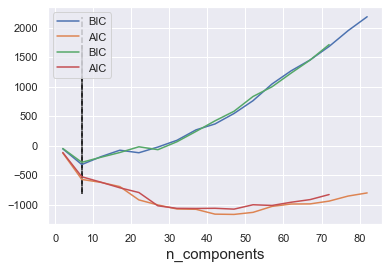

In [13]:
if __name__ == '__main__':

    df_all=ReadFromCSV('/Users/mojganmazouchi/Desktop/route/all_data.csv') 
    df=data_manipulation(df_all) #(107498, 11)
    df.shape
    #GMM_Model(df,'/Final/')
    robustness_check('West Bengal_Tripura', df, '/robustness/')